# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [4]:
!pip install palmerpenguins
import pandas as pd
from palmerpenguins import load_penguins
penguins = load_penguins()


In [7]:
penguins.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007


In [26]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [52]:
cols = ['bill_depth_mm','bill_length_mm','flipper_length_mm','body_mass_g','year',
        'species','island','sex']
base = penguins[cols].dropna().copy()


y = base['species']                               #
X = base.drop(columns='species')


X = pd.get_dummies(X, columns=['island','sex'], drop_first=True, dtype='int64')


Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

In [60]:
# Two kNN models

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

num_cols = [c for c in ['bill_depth_mm','bill_length_mm','flipper_length_mm','body_mass_g','year']
            if c in X.columns]

pre = ColumnTransformer([('num', StandardScaler(), num_cols)],
                        remainder='passthrough')  # keep dummies as 0/1

pipe = Pipeline([('pre', pre), ('knn', KNeighborsClassifier())])

param_grid = {'knn__n_neighbors': [1,3,5,7,9,11,15,21,31,41,51]}  # (optional) add 'knn__weights': ['uniform','distance']

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gcv = GridSearchCV(pipe, param_grid, cv=cv,
                   scoring='accuracy', n_jobs=-1,
                   return_train_score=True, refit=True)

gcv.fit(X, y)

print("Best params:", gcv.best_params_)
print("Best CV accuracy:", gcv.best_score_)


Best params: {'knn__n_neighbors': 21}
Best CV accuracy: 0.9939846223428311


In [63]:
#one-SE rule: pick the largest k whose CV error is within one SE of the minimum

acc = gcv.cv_results_['mean_test_score']
std = gcv.cv_results_['std_test_score']
ks  = np.array([int(v) for v in gcv.cv_results_['param_knn__n_neighbors']])
K   = gcv.cv.get_n_splits()

best_idx = int(np.argmax(acc))
best_k   = int(ks[best_idx])
one_se   = std[best_idx] / np.sqrt(K)
thr      = acc[best_idx] - one_se

cand = ks[(acc >= thr) & (ks != best_k)]
if cand.size:
    alt_k = int(cand.max())              # largest k within 1 SE, not equal to best
else:
    # fallback: second-best mean accuracy
    alt_k = int(ks[np.argsort(acc)[-2]])

print(f"Best k: {best_k}, one-SE alt k: {alt_k}")


Best k: 21, one-SE alt k: 15


In [65]:
from sklearn.neighbors import KNeighborsClassifier

knn21 = Pipeline([('pre', pre), ('knn', KNeighborsClassifier(n_neighbors=21))])
knn21.fit(X, y)


/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bill_depth_mm',
                                                   'bill_length_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g', 'year'])])),
                ('knn', KNeighborsClassifier(n_neighbors=21))])

In [66]:
knn15 = Pipeline([('pre', pre), ('knn', KNeighborsClassifier(n_neighbors=15))])
knn15.fit(X, y)


/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bill_depth_mm',
                                                   'bill_length_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g', 'year'])])),
                ('knn', KNeighborsClassifier(n_neighbors=15))])

In [81]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree3 = Pipeline([
    ("pre", pre),
    ("decision_tree", DecisionTreeClassifier(max_depth=3, random_state=0))
]).fit(X, y)

tree6 = Pipeline([
    ("pre", pre),
    ("decision_tree", DecisionTreeClassifier(max_depth=6, random_state=0))
]).fit(X, y)


In [80]:
knn_k1 = 21
knn_k2 = 15

models = {
    f'kNN (k={knn_k1})': knn21,
    f'kNN (k={knn_k2})': knn15,
    'Tree (depth=3)':   tree3,
    'Tree (depth=6)':   tree6,
}


import numpy as np, pandas as pd
from sklearn.metrics import (
    confusion_matrix, accuracy_score, classification_report,
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize

def evaluate_model(name, model, X_te, y_te):
    y_hat = model.predict(X_te)
    proba = model.predict_proba(X_te)

    classes = model.named_steps['clf'].classes_ if 'clf' in model.named_steps else model.classes_
    print(f'\n=== {name} ===')
    # Confusion matrix
    cm = confusion_matrix(y_te, y_hat, labels=classes)
    print(pd.DataFrame(cm, index=[f"true_{c}" for c in classes],
                          columns=[f"pred_{c}" for c in classes]))
    # Accuracy
    acc = accuracy_score(y_te, y_hat)
    print(f'Accuracy: {acc:.3f}')

    # Precision / Recall / F1 per class
    print('\nPrecision / Recall / F1 by species:')
    print(classification_report(y_te, y_hat, target_names=classes, digits=3))

    # AUC
    y_bin = label_binarize(y_te, classes=classes)
    aucs  = roc_auc_score(y_bin, proba, average=None)
    print('AUC per species:', {cls: round(a, 3) for cls, a in zip(classes, aucs)})

for name, m in models.items():
    evaluate_model(name, m, X_te, y_te)


=== kNN (k=21) ===
                pred_Adelie  pred_Chinstrap  pred_Gentoo
true_Adelie              37               0            0
true_Chinstrap            0              17            0
true_Gentoo               0               0           30
Accuracy: 1.000

Precision / Recall / F1 by species:
              precision    recall  f1-score   support

      Adelie      1.000     1.000     1.000        37
   Chinstrap      1.000     1.000     1.000        17
      Gentoo      1.000     1.000     1.000        30

    accuracy                          1.000        84
   macro avg      1.000     1.000     1.000        84
weighted avg      1.000     1.000     1.000        84

AUC per species: {'Adelie': np.float64(1.0), 'Chinstrap': np.float64(1.0), 'Gentoo': np.float64(1.0)}

=== kNN (k=15) ===
                pred_Adelie  pred_Chinstrap  pred_Gentoo
true_Adelie              37               0            0
true_Chinstrap            0              17            0
true_Gentoo              

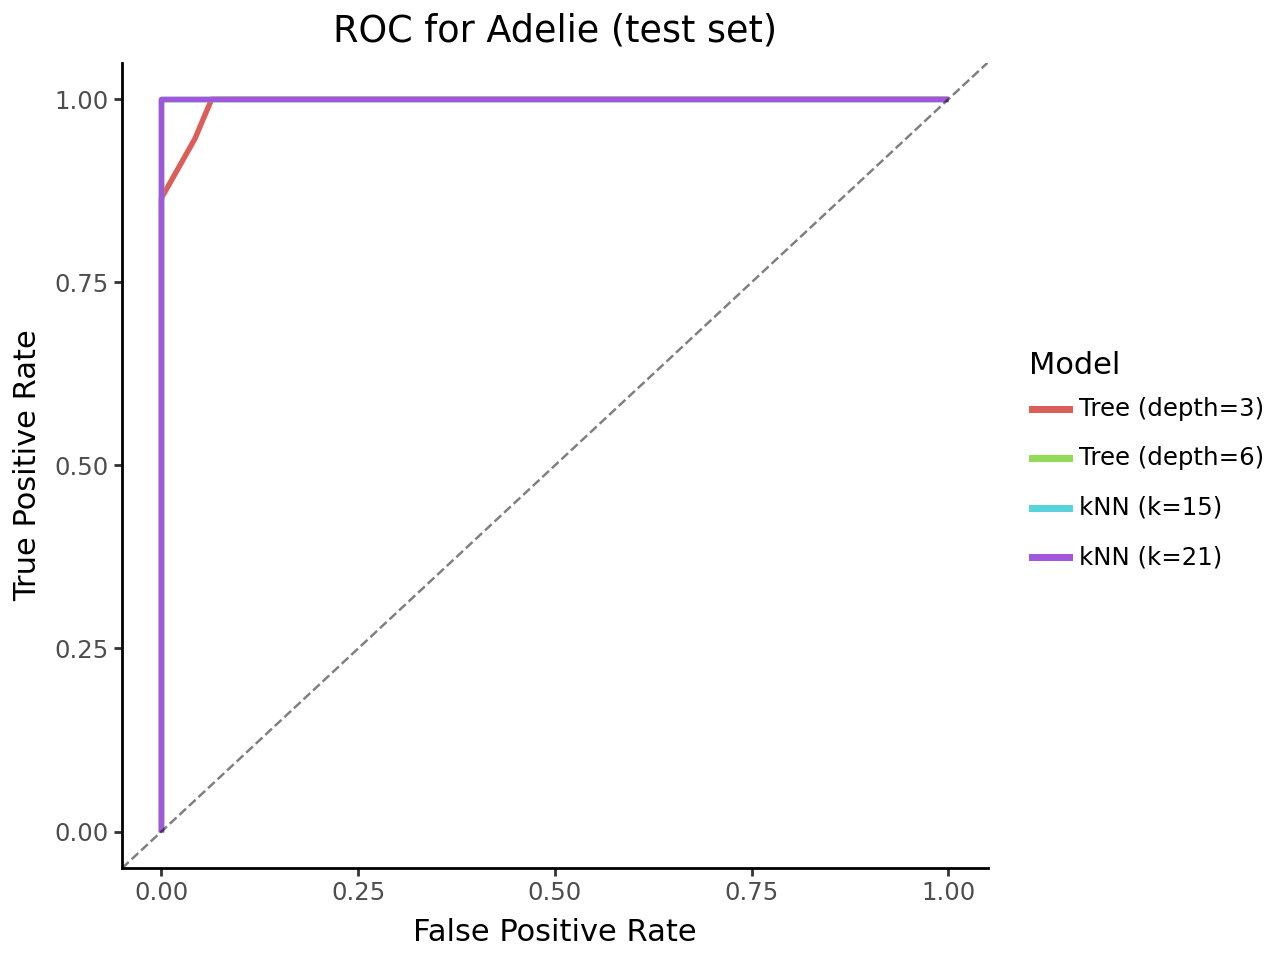

In [79]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from plotnine import ggplot, aes, geom_line, geom_abline, labs, theme_classic, theme, element_text

roc_species = "Adelie"

classes = list(next(iter(models.values())).named_steps['clf'].classes_)
i = classes.index(roc_species)
y_bin = (y_te == roc_species).astype(int).to_numpy()

rows = []
for name, m in models.items():
    proba = m.predict_proba(X_te)[:, i]
    fpr, tpr, _ = roc_curve(y_bin, proba)
    auc = roc_auc_score(y_bin, proba)
    rows.append(pd.DataFrame({"fpr": fpr, "tpr": tpr, "Model": name, "AUC": auc}))

roc_df = pd.concat(rows, ignore_index=True)

p_roc = (
    ggplot(roc_df, aes("fpr", "tpr", color="Model"))
    + geom_line(size=1.1)
    + geom_abline(linetype="dashed", alpha=0.5)
    + labs(x="False Positive Rate", y="True Positive Rate",
           title=f"ROC for {roc_species} (test set)")
    + theme_classic()
)
p_roc
